## Imports

In [1]:
import random

import pytorch_lightning
import torchmetrics
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from tqdm import tqdm
import torch
from pathlib import Path
from pytorch_lightning import seed_everything
from torch.nn import functional as F

from la.modules.module import CNN
from la.pl_modules.pl_module import MyLightningModule
from la.utils.utils import MyDatasetDict
from backports.strenum import StrEnum
from enum import auto
from nn_core.common import PROJECT_ROOT

import hdf5storage
from torch.nn.functional import mse_loss, pairwise_distance
from torchmetrics.functional import pearson_corrcoef, spearman_corrcoef

from hydra.core.global_hydra import GlobalHydra
from hydra import compose, initialize
from omegaconf import OmegaConf
from datasets import concatenate_datasets


/home/donato/miniconda3/envs/la/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/donato/miniconda3/envs/la/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")
/home/donato/PycharmProjects/latent-aggregation/src/la/pl_modules/pl_module.py:144: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=str(PROJECT_ROOT / "conf"), config_name="default")


In [2]:
from tueplots import bundles

seed_everything(43)
bundles.icml2022()

2023-04-12 08:55:36 INFO     Global seed set to 43                              ]8;id=167898;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py\pytorch_lightning.utilities.seed]8;;\:]8;id=159653;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py#71\71]8;;\

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

## Load data


In [3]:
GlobalHydra.instance().clear()
initialize(config_path="../conf")
cfg = compose(config_name="aggr_exp")

/tmp/ipykernel_61065/1270010872.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../conf")


In [4]:
data: MyDatasetDict = MyDatasetDict.load_from_disk(dataset_dict_path=str(cfg.nn.output_path))
num_tasks = data["metadata"]["num_tasks"]

## Focus on training samples


### Sort the two datasets in the same way using index

In [5]:
for task_ind in range(0, num_tasks + 1):
    data[f"task_{task_ind}_train"] = data[f"task_{task_ind}_train"].sort("id")
    data[f"task_{task_ind}_test"] = data[f"task_{task_ind}_test"].sort("id")

2023-04-12 08:55:38 WARNING  Loading cached sorted indices for dataset at               ]8;id=387844;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=704272;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#4005\4005]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_1_train/cache-2cf6806841230add.arr                            
                             ow                                                                                    

                    WARNING  Loading cached sorted indices for dataset at               ]8;id=627895;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=522476;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#4005\4005]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_1_test/cache-be0909568c9419bb.arro                            
                             w                                                                                     

                    WARNING  Loading cached sorted indices for dataset at               ]8;id=604630;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=390463;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#4005\4005]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_2_train/cache-130621a9511d4a4b.arr                            
                             ow                                                                                    

                    WARNING  Loading cached sorted indices for dataset at               ]8;id=929571;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=792007;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#4005\4005]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_2_test/cache-168afc072894e9c4.arro                            
                             w                                                                                     

                    WARNING  Loading cached sorted indices for dataset at               ]8;id=60521;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=892207;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#4005\4005]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_3_train/cache-39872266e9b89303.arr                            
                             ow                                                                                    

                    WARNING  Loading cached sorted indices for dataset at               ]8;id=160922;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=100393;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#4005\4005]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_3_test/cache-7ef3c3a5efda7980.arro                            
                             w                                                                                     

                    WARNING  Loading cached sorted indices for dataset at               ]8;id=134956;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=809816;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#4005\4005]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_4_train/cache-ecf18df914876d75.arr                            
                             ow                                                                                    

                    WARNING  Loading cached sorted indices for dataset at               ]8;id=603097;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=190672;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#4005\4005]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_4_test/cache-9c009c5b262d9973.arro                            
                             w                                                                                     

### Subspaces, embeddings from classifiers trained on a subset of the classes


#### Map the local labels back to global

In [6]:
for task_ind in range(1, num_tasks + 1):

    global_to_local_map = data["metadata"]["global_to_local_class_mappings"][f"task_{task_ind}"]
    local_to_global_map = {v: int(k) for k, v in global_to_local_map.items()}

    data[f"task_{task_ind}_train"] = data[f"task_{task_ind}_train"].map(
        lambda row: {"fine_label": local_to_global_map[row["fine_label"].item()]}
    )

2023-04-12 08:55:39 WARNING  Loading cached processed dataset at                        ]8;id=195684;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=987657;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_1_train/cache-9348f29176859f39.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=288651;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=931924;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_2_train/cache-76498e407315c556.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=897253;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=853097;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_3_train/cache-737288e4ce3db6c2.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=712247;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=64004;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_4_train/cache-ad7ef90dc027ae95.arr                            
                             ow                                                                                    

# Obtain anchors

### Get shared samples indices
Get the indices of samples from the shared classes, we will sample anchors only from these ones

In [7]:
num_shared_samples = data["metadata"]["num_train_samples_per_class"] * data["metadata"]["num_shared_classes"]
shared_classes = set(data["metadata"]["shared_classes"])

for task_ind in range(num_tasks + 1):
    data[f"task_{task_ind}_train"] = data[f"task_{task_ind}_train"].map(
        lambda row: {"shared": row["fine_label"].item() in shared_classes}
    )

2023-04-12 08:55:40 WARNING  Loading cached processed dataset at                        ]8;id=825109;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=678580;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_0_train/cache-ff6bf03edaeb0737.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=554582;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=696370;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_1_train/cache-b47d597fb6e3f132.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=889569;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=84044;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_2_train/cache-81a5d42b8cb95ace.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=620136;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=281151;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_3_train/cache-145fc1a79d25b9d4.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=633843;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=73768;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_4_train/cache-85ef0756365ddd99.arr                            
                             ow                                                                                    

### Get non shared samples indices

In [8]:
num_classes_per_task = data["metadata"]["num_shared_classes"] + data["metadata"]["num_novel_classes_per_task"]
num_train_samples_per_task = data["metadata"]["num_train_samples_per_class"] * num_classes_per_task

### Sample anchor indices

In [9]:
num_anchors = 256

shared_indices = []

for task_ind in range(num_tasks + 1):
    # get the indices of samples having shared to True
    task_shared_indices = data[f"task_{task_ind}_train"]["id"][data[f"task_{task_ind}_train"]["shared"]].tolist()
    shared_indices.append(task_shared_indices)

In [10]:
for task_i in range(num_tasks + 1):
    for task_j in range(task_i, num_tasks + 1):
        assert shared_indices[task_i] == shared_indices[task_j]

In [11]:
anchor_indices = random.sample(shared_indices[0], num_anchors)

In [12]:
for task_ind in range(num_tasks + 1):
    data[f"task_{task_ind}_train"] = data[f"task_{task_ind}_train"].map(
        lambda row: {"anchor": row["id"].item() in anchor_indices}
    )

2023-04-12 08:55:41 WARNING  Loading cached processed dataset at                        ]8;id=487419;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=61899;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_0_train/cache-fcea69add60ef170.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=229671;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=937721;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_1_train/cache-03e28f9917f1df34.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=221766;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=256470;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_2_train/cache-761b8010949dd147.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=937288;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=116320;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_3_train/cache-74bc4ff528e8ea11.arr                            
                             ow                                                                                    

                    WARNING  Loading cached processed dataset at                        ]8;id=645696;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py\datasets.arrow_dataset]8;;\:]8;id=916068;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/datasets/arrow_dataset.py#2993\2993]8;;\
                             /home/donato/PycharmProjects/latent-aggregation/data/embed                            
                             ded_cifar100_tasks/task_4_train/cache-c91ea2702e2f7280.arr                            
                             ow                                                                                    

In [13]:
centering = False
if centering:
    for task_ind in range(num_tasks + 1):
        embedding_mean = data[f"task_{task_ind}_train"]["embedding"].mean(dim=0)
        data[f"task_{task_ind}_train"] = data[f"task_{task_ind}_train"].map(
            lambda row: {"embedding": row["embedding"] - embedding_mean}
        )

### Select the anchors

In [14]:
anchors = []
for i in tqdm(range(0, num_tasks + 1)):
    task_i_anchors = data[f"task_{i}_train"]["embedding"][data[f"task_{i}_train"]["anchor"]]
    anchors.append(task_i_anchors)

print(anchors[0].shape)

100%|██████████| 5/5 [00:00<00:00, 21.23it/s]

torch.Size([256, 256])


# Map to relative spaces

In [15]:
relatives = []

for task_ind in range(0, num_tasks + 1):
    task_embeddings = data[f"task_{task_ind}_train"]["embedding"]
    task_anchors = anchors[task_ind]

    abs_space = F.normalize(task_embeddings, p=2, dim=-1)
    norm_anchors = F.normalize(task_anchors, p=2, dim=-1)

    rel_space = abs_space @ norm_anchors.T

    # _, _, Vt = torch.linalg.svd(norm_anchors)

    # Project all X onto the anchor-space
    # rel_space = torch.einsum("nd,ad -> na", abs_space, Vt)

    relatives.append(rel_space)

In [16]:
from datasets import Dataset

for task_ind in range(0, num_tasks + 1):

    dataset_dict = data[f"task_{task_ind}_train"].to_dict()

    dataset_dict["relative_embeddings"] = relatives[task_ind].tolist()

    dataset = Dataset.from_dict(dataset_dict)

    data[f"task_{task_ind}_train"] = dataset

In [17]:
del relatives
del dataset_dict

In [18]:
for task_ind in range(0, num_tasks + 1):
    data[f"task_{task_ind}_train"].set_format(
        type="torch", columns=["relative_embeddings", "embedding", "fine_label", "id", "shared"]
    )

### Average the shared samples

In [19]:
shared_samples = []
disjoint_samples = []

for task_ind in range(1, num_tasks + 1):
    task_shared_samples = data[f"task_{task_ind}_train"].filter(lambda row: row["shared"]).sort("id")

    task_novel_samples = data[f"task_{task_ind}_train"].filter(lambda row: ~row["shared"])

    shared_samples.append(task_shared_samples)
    disjoint_samples.append(task_novel_samples)

Filter:   0%|          | 0/42500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/42500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/42500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/42500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/42500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/42500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/42500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/42500 [00:00<?, ? examples/s]

In [20]:
novel_samples = concatenate_datasets(disjoint_samples)

In [21]:
shared_samples

[Dataset({
     features: ['img', 'fine_label', 'coarse_label', 'id', 'embedding', 'shared', 'anchor', 'relative_embeddings'],
     num_rows: 40000
 }),
 Dataset({
     features: ['img', 'fine_label', 'coarse_label', 'id', 'embedding', 'shared', 'anchor', 'relative_embeddings'],
     num_rows: 40000
 }),
 Dataset({
     features: ['img', 'fine_label', 'coarse_label', 'id', 'embedding', 'shared', 'anchor', 'relative_embeddings'],
     num_rows: 40000
 }),
 Dataset({
     features: ['img', 'fine_label', 'coarse_label', 'id', 'embedding', 'shared', 'anchor', 'relative_embeddings'],
     num_rows: 40000
 })]

In [22]:
novel_samples

Dataset({
    features: ['img', 'fine_label', 'coarse_label', 'id', 'embedding', 'shared', 'anchor', 'relative_embeddings'],
    num_rows: 10000
})

In [23]:
del disjoint_samples

for task_ind in range(1, num_tasks + 1):
    del data[f"task_{task_ind}_train"]

In [24]:
# compute the mean of the shared_samples and put them back in the dataset
# Extract the 'embedding' columns from each dataset

shared_rel_embeddings = [dataset["relative_embeddings"] for dataset in shared_samples]

# Calculate the mean of the embeddings for each sample
mean_embeddings = torch.mean(torch.stack(shared_rel_embeddings), dim=0)

In [25]:
# Create a new dataset with the same features as the original datasets
new_features = shared_samples[0].features.copy()

# Replace the 'embedding' column in the new dataset with the mean embeddings
new_data = {column: shared_samples[0][column] for column in new_features}
new_data["relative_embeddings"] = mean_embeddings.tolist()

# Create the new Hugging Face dataset
shared_dataset = Dataset.from_dict(new_data, features=new_features)
del new_data

### Concat the task-specific samples and the shared samples to go to the merged space

In [26]:
merged_dataset = concatenate_datasets([shared_dataset, novel_samples])
del shared_dataset
del novel_samples

In [27]:
merged_dataset = merged_dataset.sort("id")
original_dataset = data[f"task_0_train"].sort("id")

In [28]:
merged_dataset.set_format(type="torch", columns=["relative_embeddings", "fine_label", "coarse_label"])
original_dataset.set_format(type="torch", columns=["relative_embeddings", "fine_label", "coarse_label"])

In [29]:
merged_space = merged_dataset["relative_embeddings"]
original_space = original_dataset["relative_embeddings"]

In [30]:
original_space_y = original_dataset["fine_label"]
original_space_coarse_labels = original_dataset["coarse_label"]

# Analysis

## Whole space (all classes)

### Pick a subsample

In [31]:
subsample_dim: int = 1000
subsample_indices = random.sample(range(0, original_space.shape[0]), subsample_dim)

In [32]:
subsample_original = original_space[subsample_indices]
subsample_merged = merged_space[subsample_indices]
subsample_labels = original_space_y[subsample_indices]
subsample_coarse_labels = original_space_coarse_labels[subsample_indices]

In [33]:
sort_indices: torch.Tensor = subsample_labels.sort().indices

subsample_original_sorted: torch.Tensor = subsample_original[sort_indices]
subsample_merged_sorted: torch.Tensor = subsample_merged[sort_indices]
subsample_labels_sorted: torch.Tensor = subsample_labels[sort_indices]
subsample_coarse_labels_sorted: torch.Tensor = subsample_coarse_labels[sort_indices]

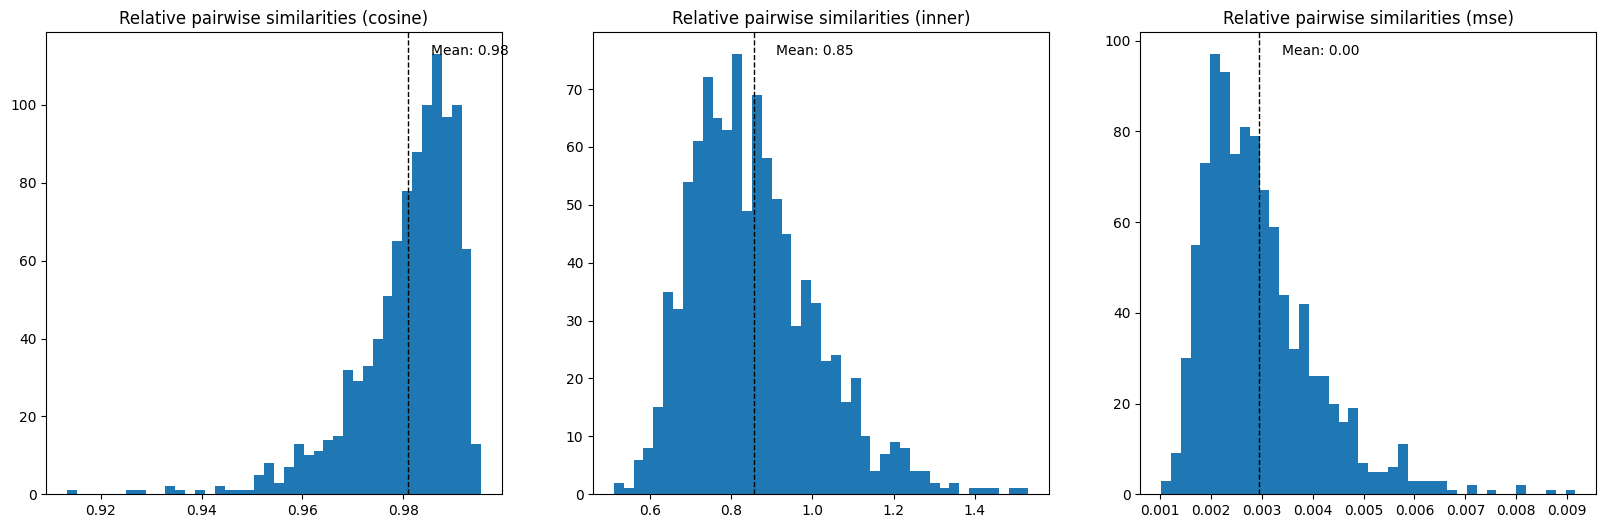

In [34]:
from la.utils.relative_analysis import plot_pairwise_dist

plot_pairwise_dist(space1=subsample_original_sorted, space2=subsample_merged_sorted, prefix="Relative")

In [35]:
from la.utils.relative_analysis import self_sim_comparison

self_sim_comparison(space1=subsample_original_sorted, space2=subsample_merged_sorted, normalize=True)

{'spearman_mean': 0.9615240693092346,
 'spearman_std': 0.024856600910425186,
 'pearson_mean': 0.966636598110199,
 'pearson_std': 0.02177584543824196,
 'cosine_mean': 0.987030029296875,
 'cosine_std': 0.013576027937233448}

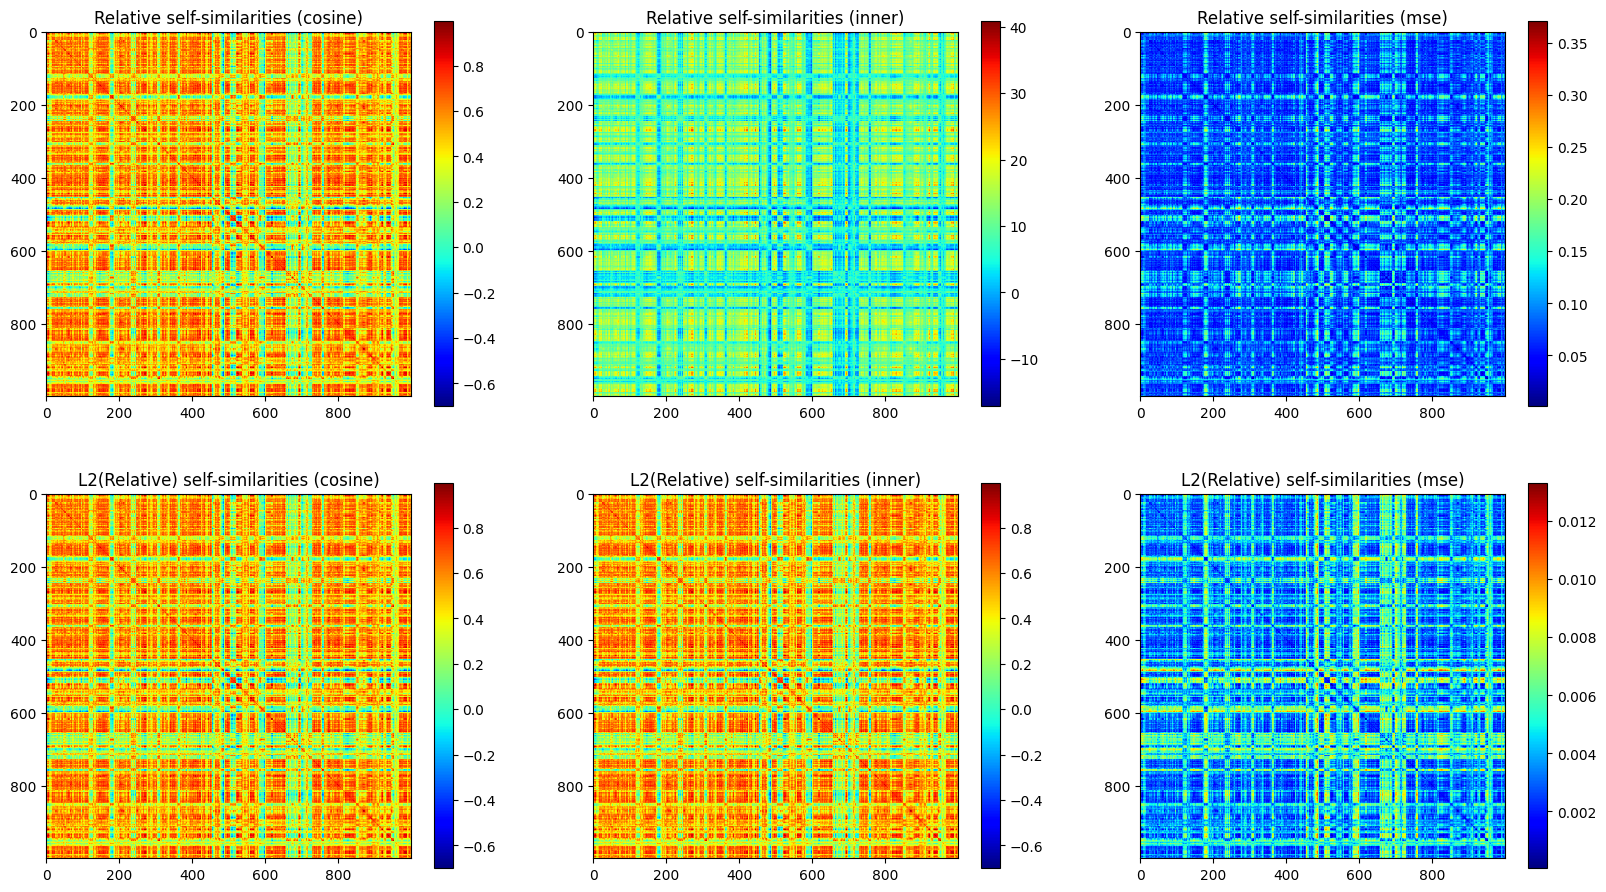

In [36]:
from la.utils.relative_analysis import plot_self_dist

plot_self_dist(space1=subsample_original_sorted, space2=subsample_merged_sorted, prefix="Relative")

In [37]:
from la.utils.relative_analysis import Reduction, reduce

x_header = [reduction.upper() for reduction in Reduction]
y_header = ["Relative Space 1", "Relative Space 2"]

spaces = [
    [
        *reduce(space1=subsample_original_sorted, space2=subsample_merged_sorted, reduction=reduction),
    ]
    for reduction in Reduction
]

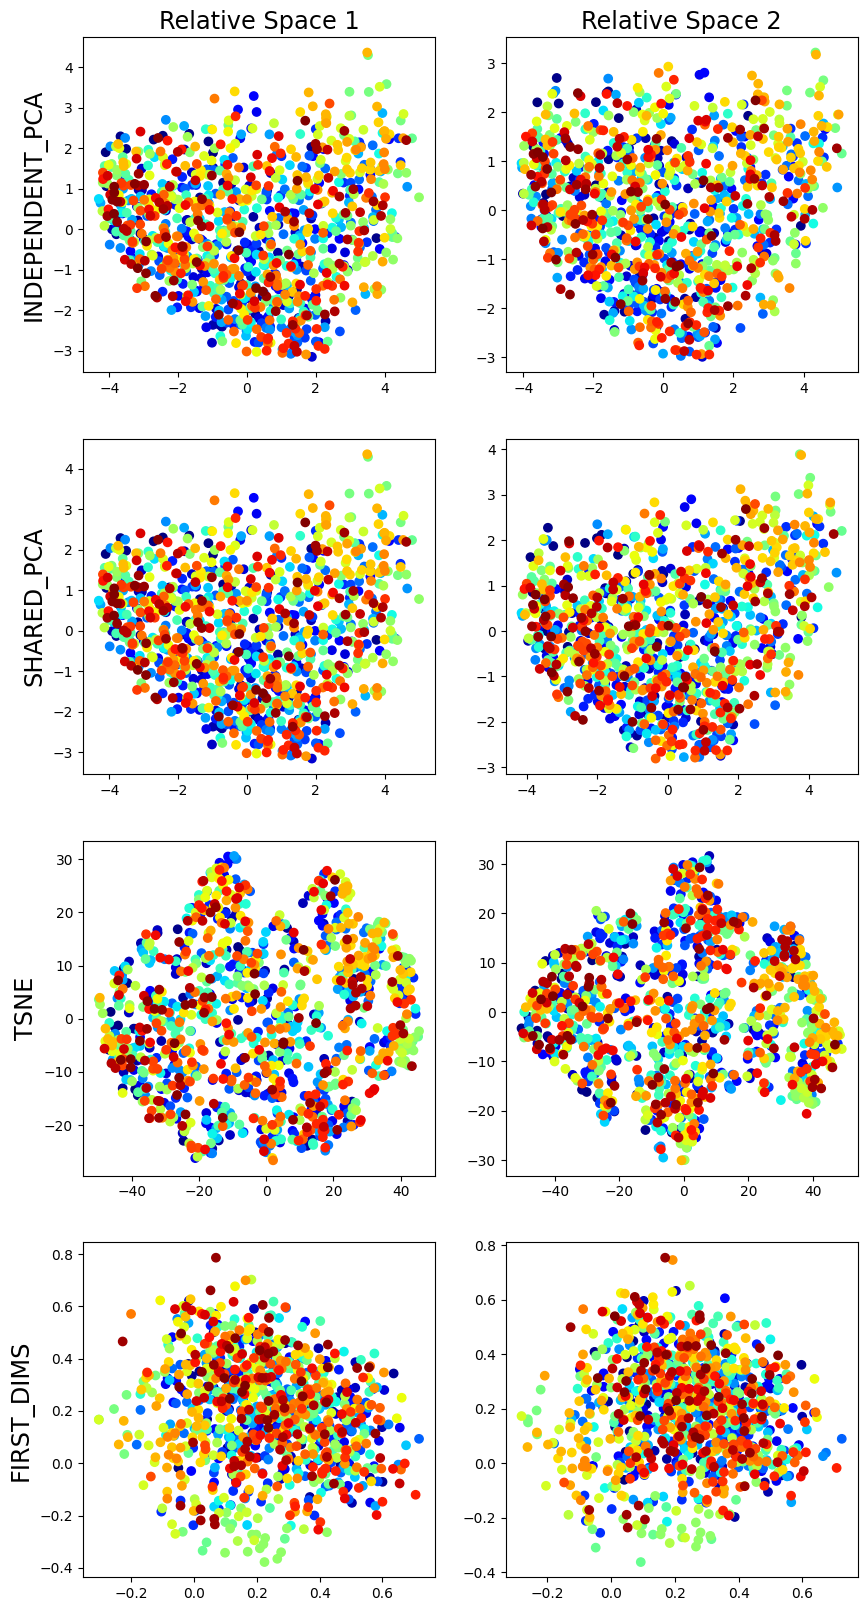

In [38]:
from la.utils.relative_analysis import plot_space_grid

fig = plot_space_grid(x_header=x_header, y_header=y_header, spaces=spaces, c=subsample_labels_sorted)
fig

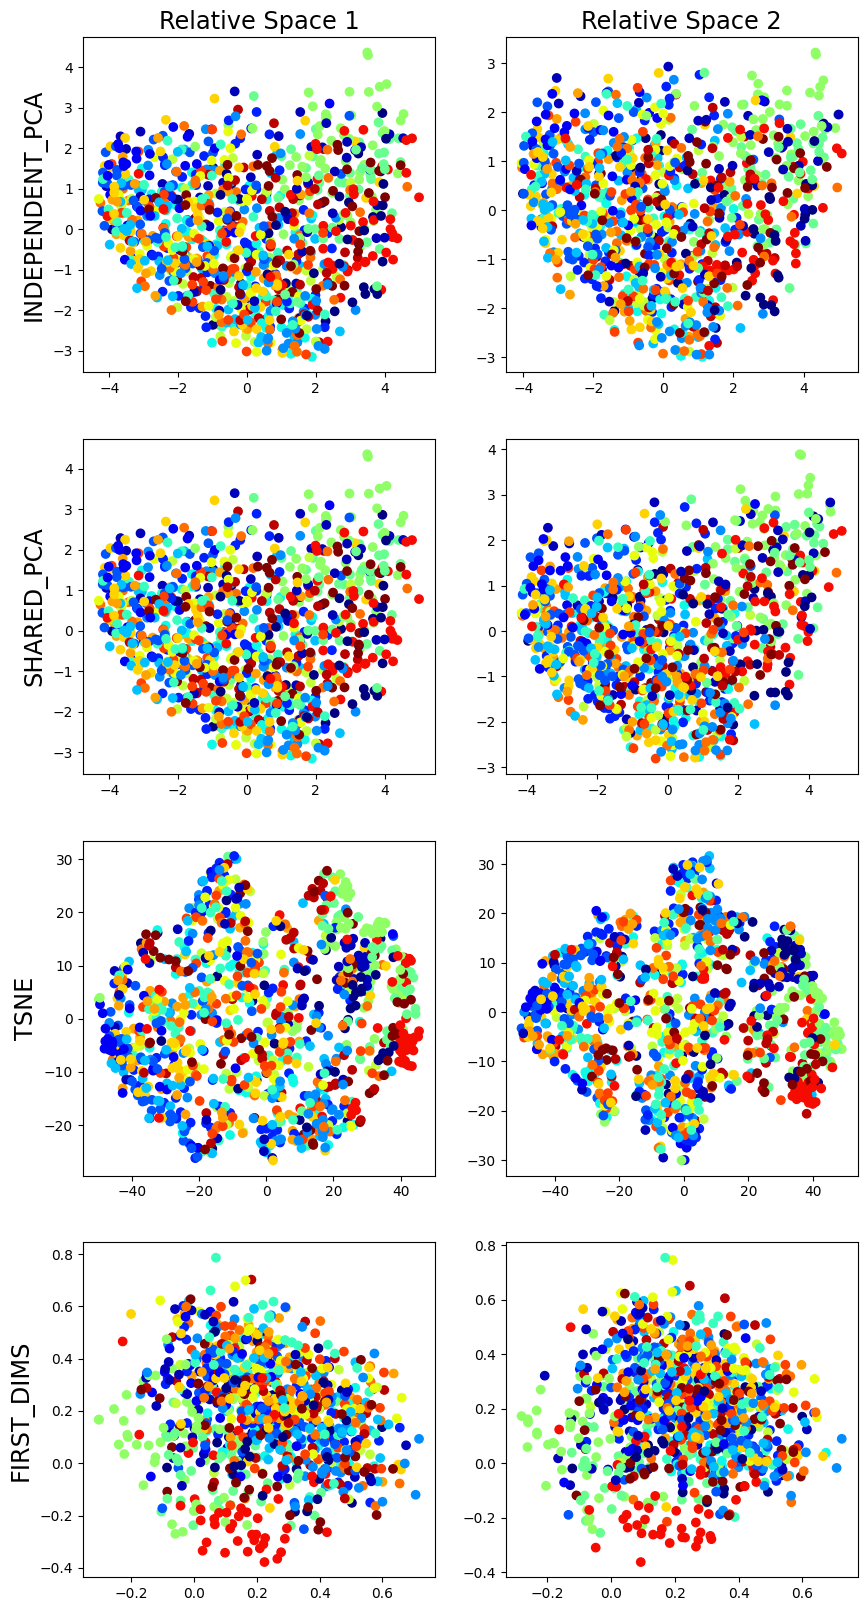

In [39]:
from la.utils.relative_analysis import plot_space_grid

fig = plot_space_grid(x_header=x_header, y_header=y_header, spaces=spaces, c=subsample_coarse_labels_sorted)
fig

## Only non-shared classes


In [40]:
non_shared_classes = set(range(100)).difference(data['metadata']['shared_classes'])
non_shared_classes

{1, 9, 15, 16, 21, 26, 30, 31, 41, 47, 51, 62, 65, 66, 70, 73, 79, 87, 89, 90}

In [41]:
merged_dataset_nonshared = merged_dataset.filter(lambda row: row["fine_label"].item() in non_shared_classes)
original_dataset_nonshared = original_dataset.filter(lambda row: row["fine_label"].item() in non_shared_classes)

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [42]:
merged_space_nonshared = merged_dataset_nonshared["relative_embeddings"]
original_space_nonshared = original_dataset_nonshared["relative_embeddings"]
original_space_y_nonshared = original_dataset_nonshared["fine_label"]
original_space_coarse_labels_nonshared = original_dataset_nonshared["coarse_label"]

### Pick a subsample

In [43]:
subsample_dim: int = 1000
subsample_indices = random.sample(range(0, original_space_nonshared.shape[0]), subsample_dim)

In [44]:
subsample_original = original_space_nonshared[subsample_indices]
subsample_merged = merged_space_nonshared[subsample_indices]
subsample_labels = original_space_y_nonshared[subsample_indices]
subsample_coarse_labels = original_space_coarse_labels_nonshared[subsample_indices]

In [45]:
sort_indices: torch.Tensor = subsample_labels.sort().indices

subsample_original_sorted: torch.Tensor = subsample_original[sort_indices]
subsample_merged_sorted: torch.Tensor = subsample_merged[sort_indices]
subsample_labels_sorted: torch.Tensor = subsample_labels[sort_indices]
subsample_coarse_labels_sorted: torch.Tensor = subsample_coarse_labels[sort_indices]

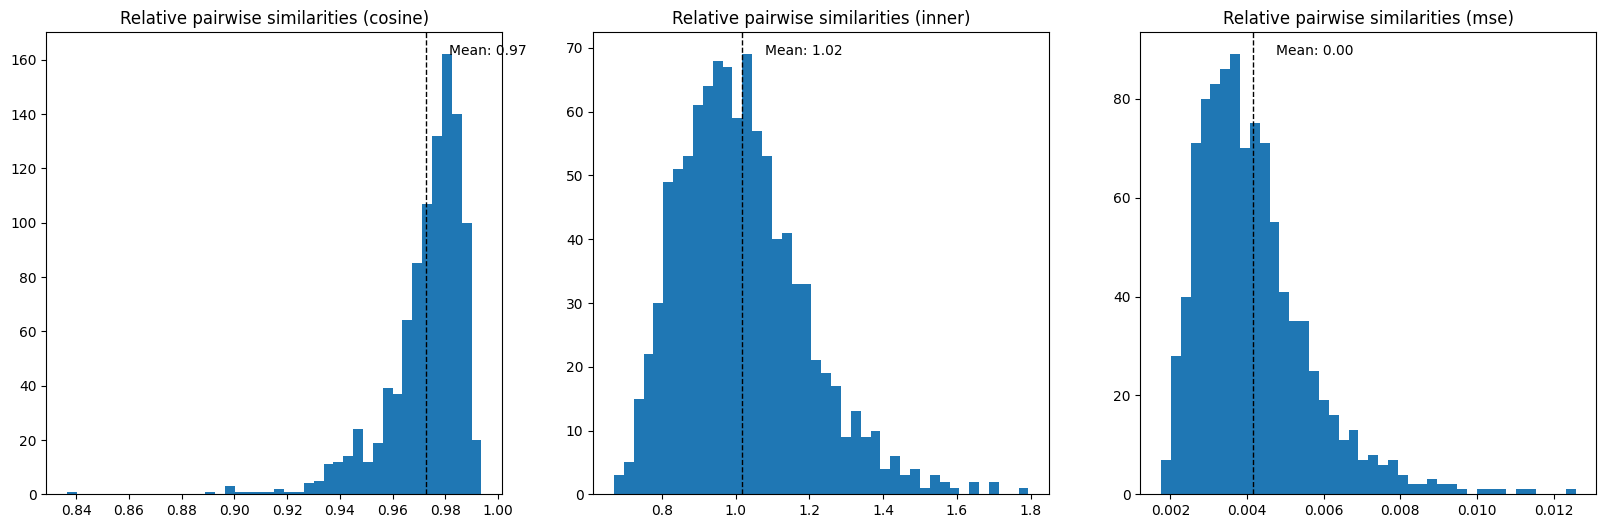

In [46]:
from la.utils.relative_analysis import plot_pairwise_dist

plot_pairwise_dist(space1=subsample_original_sorted, space2=subsample_merged_sorted, prefix="Relative")

In [47]:
from la.utils.relative_analysis import self_sim_comparison

self_sim_comparison(space1=subsample_original_sorted, space2=subsample_merged_sorted, normalize=True)

{'spearman_mean': 0.9468032717704773,
 'spearman_std': 0.03458103910088539,
 'pearson_mean': 0.9512396454811096,
 'pearson_std': 0.030489599332213402,
 'cosine_mean': 0.979958713054657,
 'cosine_std': 0.02870982140302658}

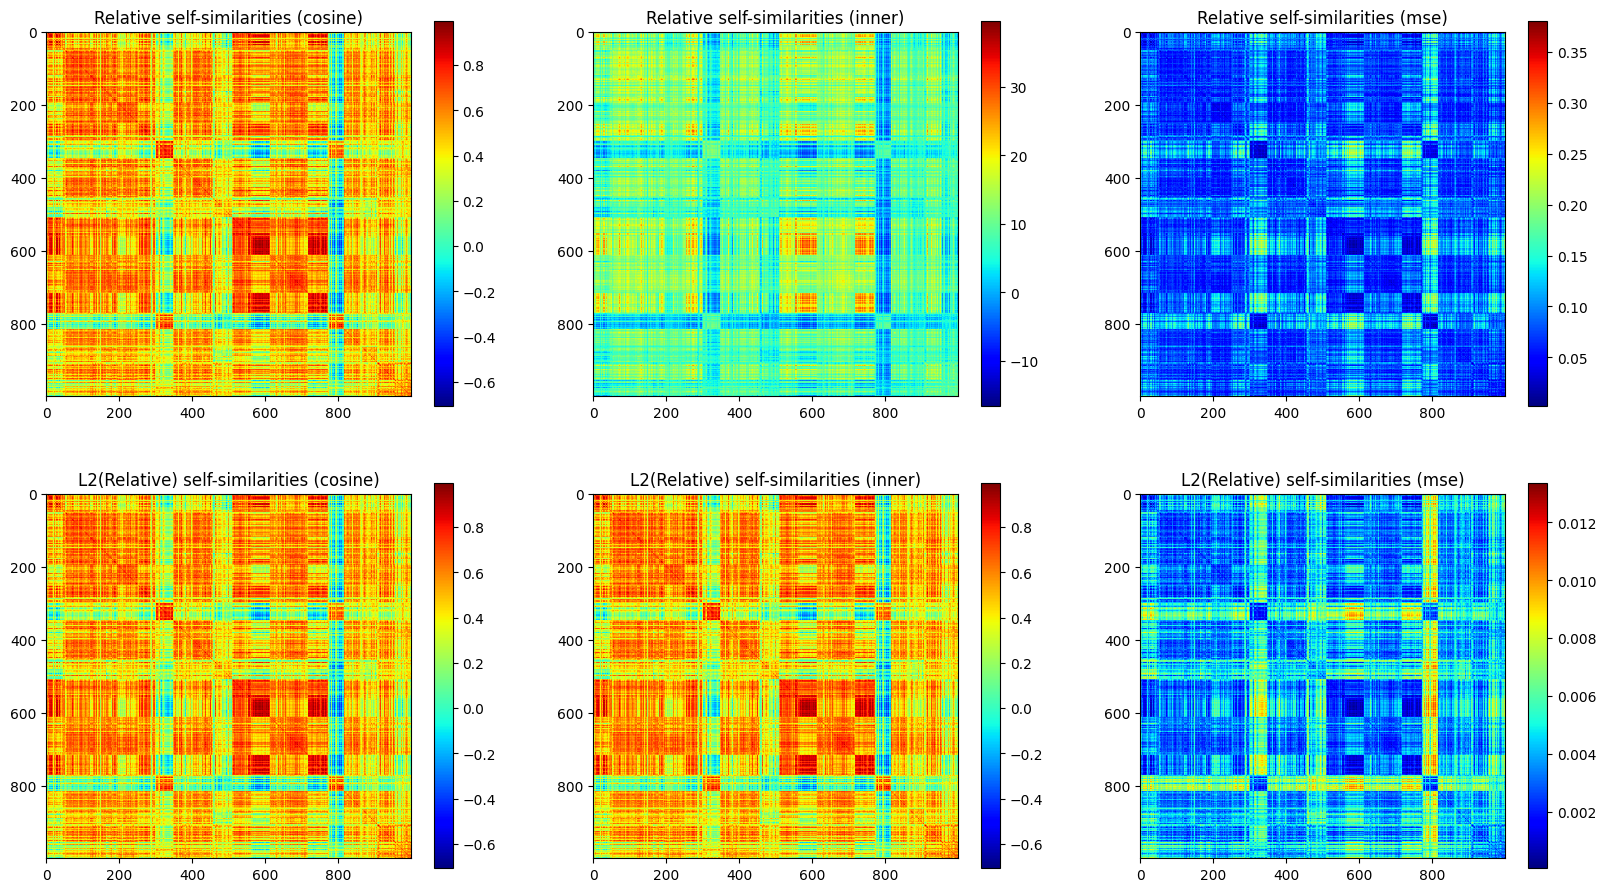

In [48]:
from la.utils.relative_analysis import plot_self_dist

plot_self_dist(space1=subsample_original_sorted, space2=subsample_merged_sorted, prefix="Relative")

In [49]:
from la.utils.relative_analysis import Reduction, reduce

x_header = [reduction.upper() for reduction in Reduction]
y_header = ["Relative Space 1", "Relative Space 2"]

spaces = [
    [
        *reduce(space1=subsample_original_sorted, space2=subsample_merged_sorted, reduction=reduction),
    ]
    for reduction in Reduction
]

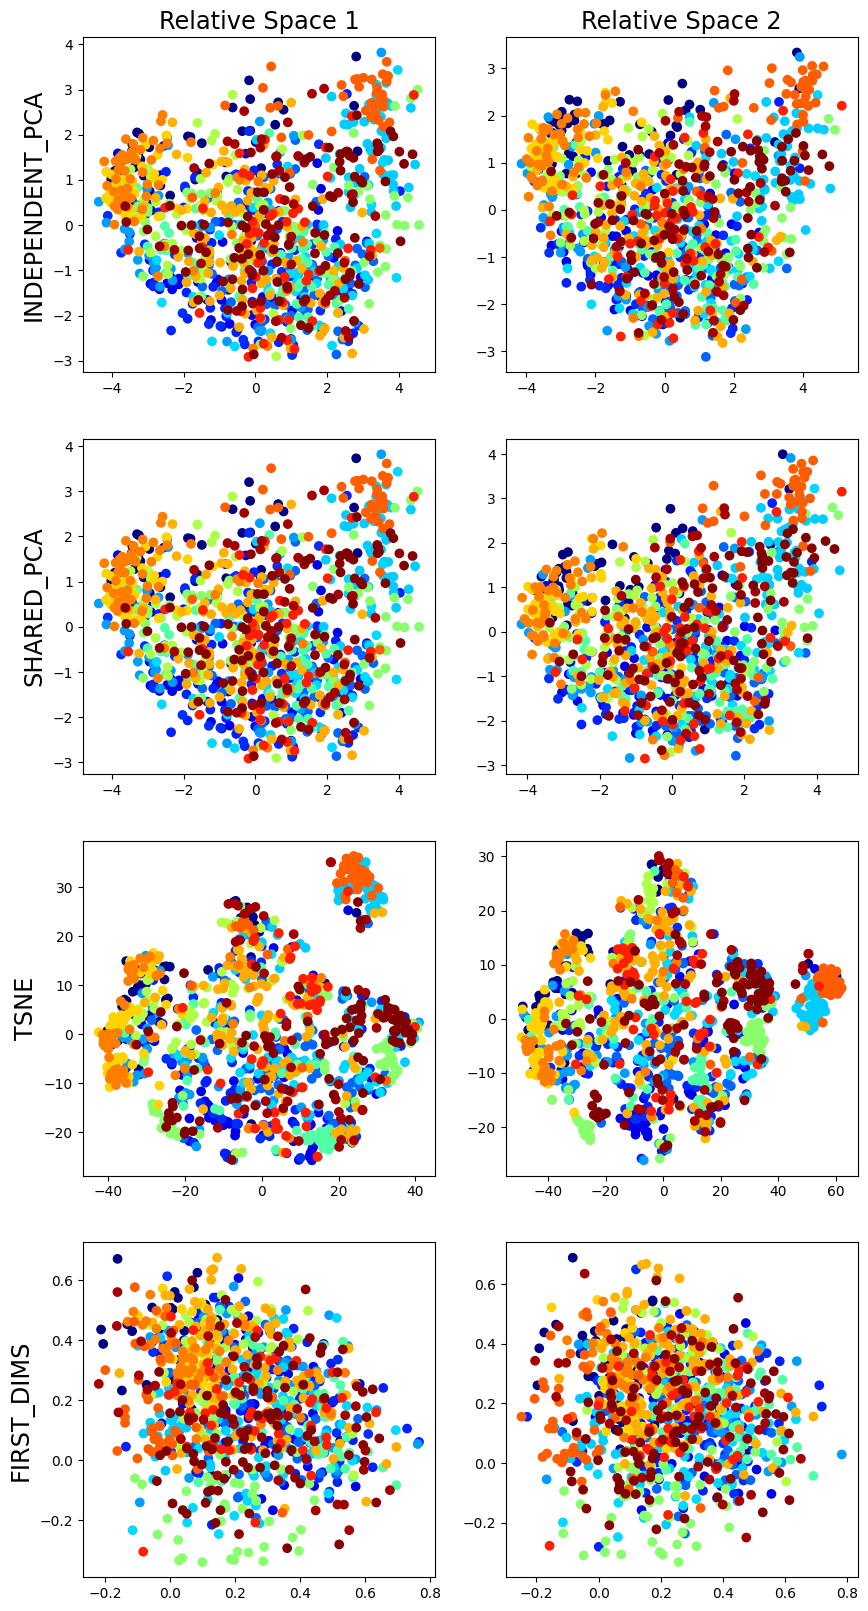

In [50]:
from la.utils.relative_analysis import plot_space_grid

fig = plot_space_grid(x_header=x_header, y_header=y_header, spaces=spaces, c=subsample_labels_sorted)
fig

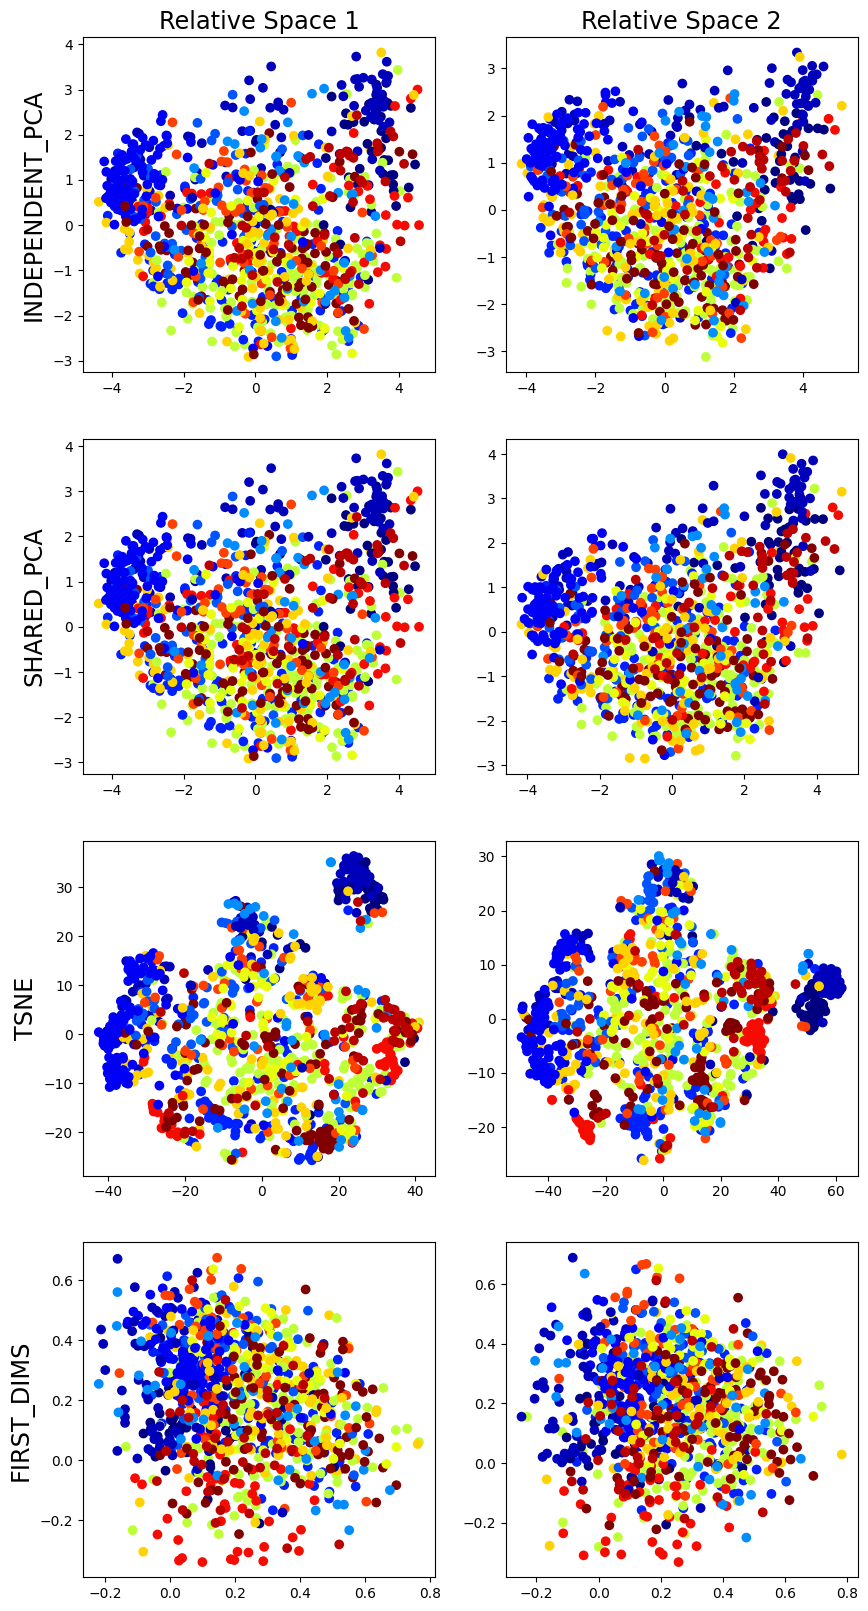

In [51]:
from la.utils.relative_analysis import plot_space_grid

fig = plot_space_grid(x_header=x_header, y_header=y_header, spaces=spaces, c=subsample_coarse_labels_sorted)
fig

# Classifier Analysis


In [94]:
from torch import nn
import pytorch_lightning
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import RichProgressBar, TQDMProgressBar

In [95]:
from functools import partial

dataloader_func = partial(
    torch.utils.data.DataLoader,
    batch_size=32,
    num_workers=4,
)

trainer_func = partial(
    Trainer,
    gpus=1,
    max_epochs=100,
    logger=False,
    enable_progress_bar=True
)

In [96]:
classifier_embed_dim = 512
num_classes = 100

def get_classifier():
    return nn.Sequential(
        nn.LayerNorm(normalized_shape=original_space.shape[1]),
        nn.Linear(num_anchors, classifier_embed_dim),
        nn.ReLU(),
        nn.Linear(classifier_embed_dim, num_classes),
    )


In [97]:
class Model(pytorch_lightning.LightningModule):
    def __init__(self, classifier: nn.Module):
        super().__init__()
        self.classifier = classifier
        self.accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['relative_embeddings'], batch['fine_label']
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['relative_embeddings'], batch['fine_label']
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss, on_step=True, prog_bar=True)

        val_acc = self.accuracy(y_hat, y)
        self.log("val_acc", val_acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch['relative_embeddings'], batch['fine_label']
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("test_loss", loss, on_step=True)

        test_acc = self.accuracy(y_hat, y)
        self.log("test_acc", test_acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

## Classifier over the original space


In [111]:
seed_everything(42)

2023-04-12 09:38:26 INFO     Global seed set to 42                              ]8;id=844962;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py\pytorch_lightning.utilities.seed]8;;\:]8;id=167414;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py#71\71]8;;\

42

In [112]:
original_classifier = Model(classifier=get_classifier())

In [113]:
trainer = trainer_func(callbacks=[pytorch_lightning.callbacks.EarlyStopping(monitor="val_loss", patience=10)])

/home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


2023-04-12 09:38:27 INFO     GPU available: True (cuda), used: True      ]8;id=288389;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=256787;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1751\1751]8;;\

                    INFO     TPU available: False, using: 0 TPU cores    ]8;id=709570;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=776646;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1754\1754]8;;\

                    INFO     IPU available: False, using: 0 IPUs         ]8;id=442417;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=33326;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1757\1757]8;;\

                    INFO     HPU available: False, using: 0 HPUs         ]8;id=529903;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=631262;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1760\1760]8;;\

In [114]:
# split dataset in train, val and test
split_dataset = original_dataset.train_test_split(test_size=0.3, seed=42)
original_dataset_train = split_dataset['train']
original_dataset_val_test = split_dataset['test']

split_val_test = original_dataset_val_test.train_test_split(test_size=0.5, seed=42)
original_dataset_val = split_val_test['train']
original_dataset_test = split_val_test['test']

In [115]:
original_train_dataloader = dataloader_func(original_dataset_train, shuffle=True)
original_val_dataloader = dataloader_func(original_dataset_val, shuffle=False)
original_test_dataloader = dataloader_func(original_dataset_test, shuffle=False)

In [116]:
trainer.fit(original_classifier, original_train_dataloader, original_val_dataloader)

/home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/donato/PycharmProjects/latent-aggregation/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]       ]8;id=681453;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/accelerators/cuda.py\pytorch_lightning.accelerators.cuda]8;;\:]8;id=735392;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/accelerators/cuda.py#57\57]8;;\

                    INFO                                               ]8;id=617889;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_summary.py\pytorch_lightning.callbacks.model_summary]8;;\:]8;id=291704;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_summary.py#83\83]8;;\
                               | Name       | Type       | Params                                                  
                             -----------------------------------------                                             
                             -                                                                                     
                             0 | classifier | Sequential | 183 K                                                   
                             1 | accuracy   | Accuracy   | 0                                                       
                             -----------------------------------------                                             
                             -                                                                                     
                             183 K     Trainable params                                                            
                             0         Non-trainable params                                                        
                             183 K     Total params                                                                
                             0.734     Total estimated model params                                                
                             size (MB)                                                                             

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [117]:
results = trainer.test(original_classifier, original_test_dataloader)
results

2023-04-12 09:39:51 INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]       ]8;id=844962;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/accelerators/cuda.py\pytorch_lightning.accelerators.cuda]8;;\:]8;id=167414;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/accelerators/cuda.py#57\57]8;;\

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.33053332567214966    │
│      test_loss_epoch      │     2.955493688583374     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 2.955493688583374, 'test_acc_epoch': 0.33053332567214966}]

## Classifier over the merged space

In [118]:
seed_everything(42)

2023-04-12 09:39:52 INFO     Global seed set to 42                              ]8;id=163032;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py\pytorch_lightning.utilities.seed]8;;\:]8;id=225772;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py#71\71]8;;\

42

In [119]:
# split dataset in train, val and test
split_dataset = merged_dataset.train_test_split(test_size=0.2, seed=42)
merged_dataset_train = split_dataset['train']
merged_dataset_val_test = split_dataset['test']

split_val_test = merged_dataset_val_test.train_test_split(test_size=0.5, seed=42)
merged_dataset_val = split_val_test['train']
merged_dataset_test = split_val_test['test']

In [120]:
merged_train_dataloader = dataloader_func(merged_dataset_train, shuffle=True)
merged_val_dataloader = dataloader_func(merged_dataset_val, shuffle=False)
merged_test_dataloader = dataloader_func(merged_dataset_test, shuffle=False)

In [121]:
classifier = get_classifier()

merged_classifier = Model(classifier=classifier)

In [124]:
trainer = trainer_func(callbacks=[pytorch_lightning.callbacks.EarlyStopping(monitor="val_loss", patience=10)])
trainer.fit(merged_classifier, merged_train_dataloader, merged_val_dataloader)

2023-04-12 09:43:18 INFO     GPU available: True (cuda), used: True      ]8;id=163032;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=225772;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1751\1751]8;;\

                    INFO     TPU available: False, using: 0 TPU cores    ]8;id=398382;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=101414;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1754\1754]8;;\

                    INFO     IPU available: False, using: 0 IPUs         ]8;id=277370;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=846335;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1757\1757]8;;\

                    INFO     HPU available: False, using: 0 HPUs         ]8;id=130889;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=967096;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1760\1760]8;;\

                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]       ]8;id=869693;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/accelerators/cuda.py\pytorch_lightning.accelerators.cuda]8;;\:]8;id=659176;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/accelerators/cuda.py#57\57]8;;\

                    INFO                                               ]8;id=605397;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_summary.py\pytorch_lightning.callbacks.model_summary]8;;\:]8;id=201629;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_summary.py#83\83]8;;\
                               | Name       | Type       | Params                                                  
                             -----------------------------------------                                             
                             -                                                                                     
                             0 | classifier | Sequential | 183 K                                                   
                             1 | accuracy   | Accuracy   | 0                                                       
                             -----------------------------------------                                             
                             -                                                                                     
                             183 K     Trainable params                                                            
                             0         Non-trainable params                                                        
                             183 K     Total params                                                                
                             0.734     Total estimated model params                                                
                             size (MB)                                                                             

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [125]:
results = trainer.test(merged_classifier, merged_test_dataloader)
results

2023-04-12 09:44:29 INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]       ]8;id=238968;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/accelerators/cuda.py\pytorch_lightning.accelerators.cuda]8;;\:]8;id=810620;file:///home/donato/miniconda3/envs/la/lib/python3.9/site-packages/pytorch_lightning/accelerators/cuda.py#57\57]8;;\

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.43619999289512634    │
│      test_loss_epoch      │    2.7791950702667236     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 2.7791950702667236,
  'test_acc_epoch': 0.43619999289512634}]